In [1]:
import csv
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from timeit import default_timer as timer

def get_data():
    net_data = []
    with open('Anaheim_net.csv', 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
        for ind, row in enumerate(reader):
            if ind > 7:
                net_data = np.append(net_data, np.array(row[1:-1]))

    net_data = np.array(net_data).reshape((-1,10))
    #print net_data[:1,:]
    num_edges = net_data.shape[0]
    print 'Number of edges: ', num_edges
    
    trips_data = []
    pairs = []
    origin = 0
    corrs = []

    with open('Anaheim_trips.csv', 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter=';', quotechar='|')
        for ind, row in enumerate(reader):
            if ind > 3:
                if len(row) > 0 and row[0][0] == 'O':
                    origin += 1
                else:
                    row = row[:-1]
                    if len(row) > 0:
                        row_ = []
                        for elem in row:
                            elem = (str(origin) + ':' + elem).split(':')
                            for ind, sub_elem in enumerate(elem):
                                elem[ind] = sub_elem.strip()
                            row_.append(map(float, elem))
                        trips_data.extend(row_)

    print 'Correspondences number: ', len(trips_data), '\n'
    print 'Origins number: ', origin
    print 'Format: [origin, destination, flow]'
    #print trips_data[:10]
    flow_data = []
    with open('Anaheim_flow.csv', 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
        for ind, row in enumerate(reader):
            if ind > 5:
                for i, elem in enumerate(row):
                    row[i] = elem.strip()
                row.remove('')
                row.remove(':')
                row.remove(';')
                #print row
                flow_data = np.append(flow_data, np.array(row))

    flow_data = np.array(flow_data).reshape((-1,4))
    return net_data, trips_data, flow_data

# Модель стабильной динамики

#### Прямая задача:

$$\Psi(f) = \sum_{e \in E \backslash E'} \int\limits_0^{f_e} \tau_e^{\mu}(z) dz + \sum_{e \in E'} f_e \bar t_e \rightarrow \min_{f = \Theta x, x \in X, \\ f_e \leq \bar f_e, ~ e \in E'}$$


#### Двойственная задача:

$$\Upsilon(t) = -  \sum_{w \in W} d_w T_w(t) + <\bar f, t - \bar t>  \rightarrow \min_{t_e \geq \bar t_e, ~ e \in E'}$$

где $T_w(t)$ - длина кратчайшего пути из $i$ в $j$ ($w = (i,j) \in W$) на графе, ребра которого взвешены вектором $t = \{t_e\}_{e \in E'}$, а функции $h_e^{\mu}(t_e)$ - гладкие вогнутые.

При этом решение изначальной задачи $f$ можно получить из формул:
$$f_e = \bar f_e - s_e, ~ e \in E', ~ \textit{где}~ s_e \geq 0 - \text{множитель Лагранжа к ограничению } t_e \geq \bar t_e $$
$$\tau_e^{\mu}(f_e) = t_e, ~ e \in E \backslash E'$$




### Восстановление решения прямой задачи

$$\phi_k(x) = V(x,y^0) + \sum_{i=0}^{k} \alpha_i \left(f(y^0) + < \nabla f(y^0), x-y^0> + h(x) \right)$$

У нас $h(x) =0 $.

$$A_k (f(x^k) + h(x^k)) \leq \min\limits_{x \in Q} \phi_k(x)$$
$$u^k = \text{arg} \min\limits_{x \in Q} \phi_k(x) = \text{arg} \min\limits_{x \in Q} \frac{1}{A_k} \phi_k(x)$$
Двойственная задача к модели стабильной динамики:
$$\Upsilon(t) = -\sum_{w \in W} d_w T_w(t) + <\bar f, t - \bar t>  \rightarrow \min_{t_e \geq \bar t_e, ~ e \in E'}$$
обозначим  $F(t) = -\sum_{w \in W} d_w T_w(t) + <\bar f, t - \bar t>$.

$$V(t,t_y^0) = \frac12 ||t - t_y^0||_2^2$$

На каждой итерации решаем задачу:
$$u^k = \text{arg} \min\limits_{t \geq \bar t} \phi_k(t) = \text{arg} \min\limits_{t \geq \bar t} \left\{ \frac1{A_k} V(t,t_y^0) + \sum_{i=0}^{k} \frac{\alpha_i}{A_k} \left( F(t_y^i) + <\nabla F(t_y^i), t-t_y^i> \right)  \right\}$$

Эквивалентная задача:
$$s^k = \text{arg} \min_t \max_{s \geq 0} \Omega_k (t,s)= \text{arg} \min_t \max_{s \geq 0} \left(\phi_k(t) + <s, \bar t - t>\right) = \\ = \text{arg} \min_t \max_{s \geq 0} \left\{ \frac1{A_k} V(t,t_y^0) + \sum_{i=0}^{k} \frac{\alpha_i}{A_k} \left( F(t_y^i) + <\nabla F(t_y^i), t-t_y^i> \right) + <s, \bar t - t> \right\} $$

Поменяем местами $\min$ и  $\max$. Найдем минимум по $t$:

Так как $\Omega_{k~~t}' (t,s) = \phi_k'(t) - s = 0$, $\Omega_{k~~tt}'' (t,s) = \phi_k''(t) = 1 > 0$ и $\phi_k'(t) = t - y^0 + \sum_{i=0}^{k} \alpha_i \nabla f(y^i)$, то:
$$t^* = \text{arg} \min_t\Omega_k (t,s) = s + y^0 - \sum_{i=0}^{k} \alpha_i \nabla f(y^i)$$

Тогда
$$s^k = \text{arg} \max_{s \geq 0} \Omega_k (t^*,s) = \text{arg} \max_{s \geq 0} \left\{ \phi_k(t^*) + <s, \bar t - t^*> \right\}  = \\ = \text{arg} \max_{s \geq 0} \left\{ \phi_k(s + y^0 - \sum_{i=0}^{k} \alpha_i \nabla f(y^i)) + <s, \bar t - (s + y^0 - \sum_{i=0}^{k} \alpha_i \nabla f(y^i))> \right\} $$

Найдем минимум:
$$s + y^0 - \sum_{i=0}^{k} \alpha_i \nabla f(y^i) - y^0 + \sum_{i=0}^{k} \alpha_i \nabla f(y^i)) + \bar t - 2s - y^0 + \sum_{i=0}^{k} \alpha_i \nabla f(y^i)) = 0$$

$$s^k = \max \left\{ \bar t - y^0 + \sum_{i=0}^{k} \alpha_i \nabla f(y^i)), 0\right\}$$

Тогда
$$f_k = \bar f - s^k$$

### Algorithm

In [23]:
def d_wT_w(t):
    global num_edges, net_data, trips_data
    G = nx.DiGraph()
    for i in xrange(num_edges):
        G.add_edge(int(net_data[i,0]), int(net_data[i,1]), weight=t[i])
    result = 0.
    lengths = nx.all_pairs_dijkstra_path_length(G)
    for i in xrange(len(trips_data)):
        result += lengths[int(trips_data[i][0])][int(trips_data[i][1])] * trips_data[i][2]
    #print 'Weighted calculated. sum d_w T_w = ', result, '\n'
    return result

def prox(z):
    return z.dot(z) / 2

def prox_grad(z):
    return z

def V(x, y):
    return prox(x - y)

def f(x):
    global weights, capacities
    return capacities.dot(x - weights) - d_wT_w(x)

def grad_d_wT_w(t):
    global num_edges, net_data, trips_data
    G = nx.DiGraph()
    for i in xrange(num_edges):
        G.add_edge(int(net_data[i,0]), int(net_data[i,1]), weight=t[i])
    paths = nx.all_pairs_dijkstra_path(G)
    grad = np.zeros(num_edges)
    for i in xrange(len(trips_data)):
        vec = np.array([ sum([(paths[int(trips_data[i][0])][int(trips_data[i][1])][j] == int(net_data[k,0]) and
                               paths[int(trips_data[i][0])][int(trips_data[i][1])][j + 1] == int(net_data[k,1])) 
                              for j in xrange(len(paths[int(trips_data[i][0])][int(trips_data[i][1])]) - 1)])
                        for k in xrange(num_edges)])
        grad += trips_data[i][2] * vec
    return grad

def grad_f(x):
    global capacities
    return capacities - grad_d_wT_w(x)

def initial_function(flow):
    return flow.dot(weights)

def optimal_t_stable_dynamic(n, EPS, MU, omega):
    global capacities, weights
    MU_tilde = MU / omega
    L = [] # list of lists
    A = [] # list of numbers
    alpha = [] # list of numbers
    y = [] # list of arrays

    L.append([])
    L[0].append(2.)
    A.append(1. / L[0][0])
    alpha.append(1. / L[0][0])


    e = np.zeros(n)
    e1 = np.ones(n)
    y.append(e)

    grad_f_y_0 = grad_f(y[0])
    grad_phi = y[0] - alpha[0] * grad_f_y_0
    x_prev = np.maximum(grad_phi, weights)
    u = x_prev

    f_y_0 = f(y[0])

    j = []
    j.append(0)

    value = (- f(x_prev) + f_y_0 + grad_f_y_0.dot(x_prev - y[0]) +
             L[0][j[0]] / 2 * np.linalg.norm(x_prev - y[0])**2 + alpha[0] * EPS / (2 * A[0]) )
    Y_prev = f(x_prev)

    while 0. > value and (j[0] < 100):
        j[0] += 1
        L[0].append(2**(j[0]) * L[0][0])
        A[0] = 1. / L[0][j[0]]
        alpha[0] = 1. / L[0][j[0]]
        x_prev = np.maximum(y[0] - alpha[0] * grad_f_y_0, weights)
        Y_prev = f(x_prev)
        value = (- Y_prev + f_y_0 + grad_f_y_0.dot(x_prev - y[0]) +
             L[0][j[0]] / 2 * np.linalg.norm(x_prev - y[0])**2 + alpha[0] * EPS / (2 * A[0]) )

    flows = np.maximum(np.zeros(n, dtype='float'), capacities - (weights - grad_phi))
    initial_prev = initial_function(flows)
    np.savetxt('Stable_dynamic_t_data0' + 'eps_' + str(EPS) + '.txt', x_prev)
    np.savetxt('Stable_dynamic_f_data0' + 'eps_' + str(EPS) + '.txt', flows)
    print 'Zero iteration is successful! j = ', j[0],' Y =', Y_prev, ' F =', initial_prev, ' \n'
    
    k = 0    
    while (k < 100 ):
        j.append(0)
        L.append([])
        L[k + 1].append(L[k][j[k]] / 2) #L_k+1^0
        alpha_next = ( (1. + A[k] * MU_tilde) / (2 * L[k + 1][j[k + 1]]) +
                      np.sqrt( (1. + A[k] * MU_tilde)/(4 * (L[k + 1][j[k + 1]])**2) +
                              (A[k] * (1. + A[k] * MU_tilde))/(L[k + 1][j[k + 1]]) ) )
        alpha.append(alpha_next)
        A.append(A[k] + alpha[k + 1])
        y.append((alpha[k + 1] * u + A[k] * x_prev)/A[k+1])
        
        grad_f_y_next = grad_f(y[k+1])
        grad_phi = u - alpha[k+1] * grad_f_y_next
        u_next = np.maximum(grad_phi, weights)
        x_next = (alpha[k + 1] * u_next + A[k] * x_prev) / A[k + 1]
        Y_next = f(x_next)
        
        value = ( f(y[k + 1]) + grad_f_y_next.dot(x_next - y[k + 1]) + 
                 (L[k + 1][j[k + 1]] / 2)  * np.linalg.norm(x_next - y[k + 1])**2 +
                 alpha[k + 1] * EPS / (2 * A[k + 1])) - Y_next

        while (value < 0. and j[k + 1] < 10):
            j[k + 1] += 1
            L[k + 1].append(2**j[k + 1] * L[k][j[k]])
            alpha[k + 1] = ( (1. + A[k] * MU_tilde) / (2 * L[k + 1][j[k + 1]]) +
                            np.sqrt( (1. + A[k] * MU_tilde)/(4 * (L[k + 1][j[k + 1]])**2) +
                                    (A[k] * (1. + A[k] * MU_tilde))/(L[k + 1][j[k + 1]]) ) )
            A[k+1] = A[k] + alpha[k + 1]
            y[k+1] = (alpha[k + 1] * u + A[k] * x_prev)/A[k+1]
            grad_f_y_next = grad_f(y[k+1])
            grad_phi = u - alpha[k+1] * grad_f_y_next
            u_next = np.maximum(grad_phi, weights)
            x_next = (alpha[k + 1] * u_next + A[k] * x_prev) / A[k + 1]
            Y_next = f(x_next)
            value = ( f(y[k + 1]) + grad_f_y_next.dot(x_next - y[k + 1]) + 
                     L[k + 1][j[k + 1]] / 2 * np.linalg.norm(x_next - y[k + 1])**2 + 
                     alpha[k + 1] * EPS / (2 * A[k + 1])) - Y_next

        k += 1
        print '\n', k, ' iteration done with j =', j[k], ':\n'

        flows = np.maximum(np.zeros(n, dtype='float'), capacities - (weights - grad_phi))
        initial_next = initial_function(flows)
        #print 'x_next: ', x_next[:10]
        #print 'flows: ', flows[:10]
        #print 'Initial function value: ', initial_next
        #print 'Dual function value: ', Y_next
        Y_DISPERANCY = np.linalg.norm(Y_next - Y_prev) / np.linalg.norm(Y_prev)
        DISPERANCY = np.linalg.norm(x_next - x_prev) / np.linalg.norm(x_prev)
        F_DISPERANCY = np.linalg.norm(initial_next - initial_prev) / np.linalg.norm(initial_prev)
        print DISPERANCY, Y_DISPERANCY, F_DISPERANCY
        #print (initial_next + Y_next) / (initial_0 + Y_0)
        #if initial_next + Y_next <= EPS * (initial_0 + Y_0):
        if Y_DISPERANCY <= EPS and F_DISPERANCY <= EPS:
            np.savetxt('Stable_dynamic_t_solution' + str(k) + 'eps_' + str(EPS) + '.txt', x_next)
            print 'Success! Iteration = ', k
            break
        x_prev = x_next
        u = u_next
        Y_prev = Y_next
        initial_prev  =initial_next
        np.savetxt('Stable_dynamic_t_data' + str(k) + 'eps_' + str(EPS) + '.txt', x_next)
        np.savetxt('Stable_dynamic_f_data' + str(k) + 'eps_' + str(EPS) + '.txt', flows)

    return x_next, Y_next

In [24]:
eps_stable_values = []
time_stable_values = []

net_data, trips_data, flow_data = get_data()
num_edges = net_data.shape[0]
capacities = np.array(map(float, net_data[:,2]))
weights = np.array(map(float, net_data[:,4]))

for EPS in [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, 0.005]:  
    print "EPS: ", EPS, '\n'
    t0 = timer() 
    MU = 0.25
    omega = 1.
    x_next, Y_next = optimal_t_stable_dynamic(num_edges, EPS, MU, omega)
    t1 = timer()

    eps_stable_values.append(EPS)
    time_stable_values.append(t1 - t0)
    print "EPS: ", EPS
    print "Solution: ", x_next[:5]
    print "value: ", Y_next
    print 'Time : ', t1 - t0, '\n'

Number of edges:  914
Correspondences number:  1406 

Origins number:  38
Format: [origin, destination, flow]
EPS:  0.1 

Zero iteration is successful! j =  10  Y = -1153294.2339  F = 3054462.42252  


1  iteration done with j = 1 :

157.820785308 71.1474506854 0.508473844972

2  iteration done with j = 1 :

0.29551913393 0.299183879321 4.90016923662e-05

3  iteration done with j = 1 :

0.102060808345 0.102233680976 3.86377189462e-05

4  iteration done with j = 0 :

0.0927532364055 0.0914184497906 0.000154928614358
Success! Iteration =  4
EPS:  0.1
Solution:  [  1.09045849e+00   2.59652657e+02   1.09045849e+00   1.24309968e+03
   1.09045849e+00]
value:  126440907.677
Time :  271.285737935 

EPS:  0.09 

Zero iteration is successful! j =  10  Y = -1153294.2339  F = 3054462.42252  


1  iteration done with j = 1 :

157.820785308 71.1474506854 0.508473844972

2  iteration done with j = 1 :

0.29551913393 0.299183879321 4.90016923662e-05

3  iteration done with j = 1 :

0.102060808345 0.10

In [50]:
for EPS in [0.0205]:  
    print "EPS: ", EPS, '\n'
    t0 = timer() 
    MU = 0.25
    omega = 1.
    x_next, Y_next = optimal_t_stable_dynamic(num_edges, EPS, MU, omega)
    t1 = timer()

    eps_stable_values[8] = (EPS)
    time_stable_values[8] = (t1 - t0)
    print "EPS: ", EPS
    print "Solution: ", x_next[:5]
    print "value: ", Y_next
    print 'Time : ', t1 - t0, '\n'

EPS:  0.0205 

Zero iteration is successful! j =  10  Y = -1153294.2339  F = 3054462.42252  


1  iteration done with j = 1 :

157.820785308 71.1474506854 0.508473844972

2  iteration done with j = 1 :

0.29551913393 0.299183879321 4.90016923662e-05

3  iteration done with j = 1 :

0.102060808345 0.102233680976 3.86377189462e-05

4  iteration done with j = 0 :

0.0927532364055 0.0914184497906 0.000154928614358

5  iteration done with j = 1 :

0.0422367585432 0.0411484823288 6.12148980297e-05

6  iteration done with j = 0 :

0.0434365928072 0.0413104899531 0.000181151880211

7  iteration done with j = 1 :

0.022083465811 0.0205086796639 7.75737899822e-05

8  iteration done with j = 0 :

0.024179032167 0.0215015976119 0.000208096222257

9  iteration done with j = 0 :

0.0244991004223 0.0200065754619 0.000320884356094
Success! Iteration =  9
EPS:  0.0205
Solution:  [  1.09045849e+00   3.04546909e+02   1.09045849e+00   1.45865818e+03
   1.09045849e+00]
value:  145760296.522
Time :  495.644

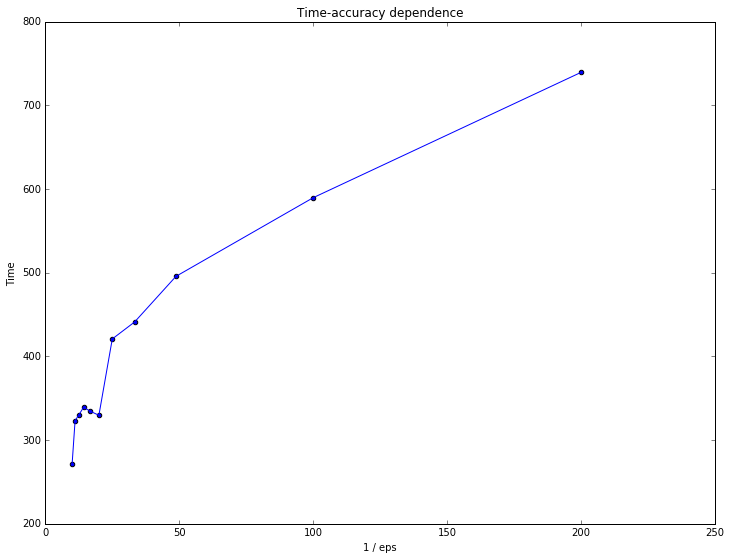

In [51]:
%matplotlib inline
def plot_eps_time(eps, times):
    plt.figure(figsize=(12,9))
    plt.scatter(1./(np.array(eps)), np.array(times))
    plt.plot(1./(np.array(eps)), np.array(times))
    plt.xlabel('1 / eps')
    plt.ylabel('Time')
    plt.title('Time-accuracy dependence')
    plt.show()

plot_eps_time(eps_stable_values, time_stable_values)

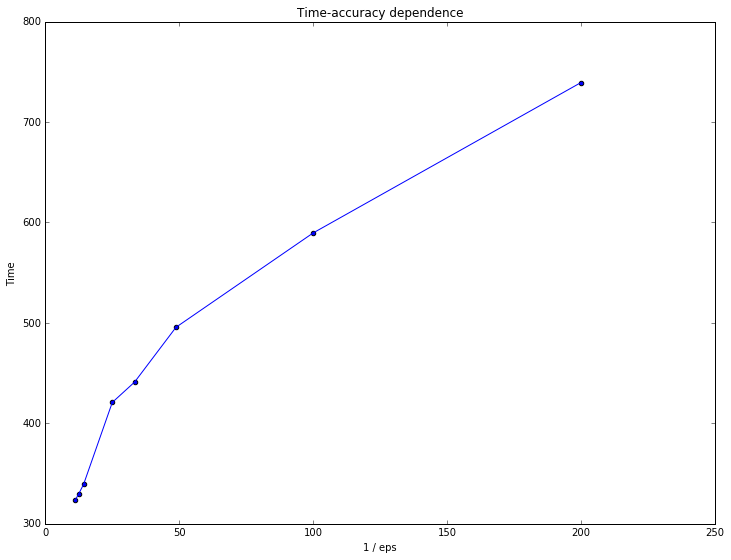

In [53]:
ind = [1,2,3,6,7,8,9,10]
plot_eps_time(np.array(eps_stable_values)[ind], np.array(time_stable_values)[ind])

# Модель Бэкмана

**BPR-функция (Bureau of Public Road)**
$$ t_e(f_e) = t_e^0 \left(1 + \gamma \left(\frac{f_e}{\bar f_e} \right)^{\frac1{\mu}} \right),$$

Для BPR-функции $\sigma^*(t_e) = \bar f_e \left(\frac{t_e - \bar t_e}{\bar t_e  \gamma} \right)^{\mu} \left( \frac{t_e - \bar t_e}{1 + \mu}\right)$.

#### Прямая задача:

$$\Psi(f) = \sum_{e \in E} \sigma_e(f_e) = \sum_{e \in E} \int\limits_0^{f_e} \tau_e(z) dz \rightarrow \min_{f = \Theta x, x \in X}$$

Для прямой задачи:
$$\Psi(f) = \sum_{e \in E} \sigma_e(f_e) = \sum_{e \in E} \int\limits_0^{f_e} \tau_e(z) dz = \sum_{e \in E} \left( f_e \bar t_e + \frac{\mu ~\bar t_e ~\gamma ~f_e^{1 + 1/\mu}}{\bar f_e^{~1 / \mu}~ (\mu + 1)} \right)$$

#### Двойственная задача:

$$\Upsilon(t) = -\sum_{w \in W} d_w T_w(t) + \sum_{e \in E} \bar f_e \left(\frac{t_e - \bar t_e}{\bar t_e  \gamma} \right)^{\mu} \left( \frac{t_e - \bar t_e}{1 + \mu}\right)  \rightarrow \min_{t_e \in dom~\sigma_e(t_e),~e \in E}$$

### Algorithm

In [60]:
import numpy as np
from timeit import default_timer as timer

def d_wT_w(t):
    global num_edges, net_data, trips_data
    G = nx.DiGraph()
    for i in xrange(num_edges):
        G.add_edge(int(net_data[i,0]), int(net_data[i,1]), weight=t[i])
    result = 0.
    lengths = nx.all_pairs_dijkstra_path_length(G)
    for i in xrange(len(trips_data)):
        result += lengths[int(trips_data[i][0])][int(trips_data[i][1])] * trips_data[i][2]
    return result

def prox(z):
    return z.dot(z) / 2

def prox_grad(z):
    return z

def V(x, y):
    return prox(x - y)

def f(x):
    global MU, gamma, weights, capacities
    return ( np.sum(capacities * (x - weights)**(MU + 1) / (weights * gamma)**MU / (1. + MU)) 
            - d_wT_w(x) )

def grad_d_wT_w(t):
    global num_edges, net_data, trips_data
    G = nx.DiGraph()
    for i in xrange(num_edges):
        G.add_edge(int(net_data[i,0]), int(net_data[i,1]), weight=t[i])
    paths = nx.all_pairs_dijkstra_path(G)
    grad = np.zeros(num_edges)
    for i in xrange(len(trips_data)):
        vec = np.array([ sum([(paths[int(trips_data[i][0])][int(trips_data[i][1])][j] == int(net_data[k,0]) and
                               paths[int(trips_data[i][0])][int(trips_data[i][1])][j + 1] == int(net_data[k,1])) 
                              for j in xrange(len(paths[int(trips_data[i][0])][int(trips_data[i][1])]) - 1)])
                        for k in xrange(num_edges)])
        grad += trips_data[i][2] * vec
    return grad

def grad_sigma(x):
    global MU, gamma, capacities, weights
    return capacities  * (x - weights)**MU / (weights**MU * gamma**MU )

def grad_f(x): # grad_f(t)  = -grad_d_wT_w(t) + grad_sigma(t)
    global MU, gamma, capacities, weights
    return -grad_d_wT_w(x) + capacities  * (x - weights)**MU / (weights**MU * gamma**MU )

def initial_Beckmann(flows):
    global weights, MU, gamma, capacities
    return np.sum(flows.dot(weights) + MU * gamma * weights * flows**(1. + 1./MU) / ((MU + 1.) * capacities**(1. / MU)))
    
def optimal_t_beckmann(n, EPS, MU, omega, gamma):
    global capacities, weights
    MU_tilde = MU / omega
    L = [] 
    A = [] 
    alpha = []
    y = [] 

    L.append([])
    L[0].append(2.)
    A.append(1. / L[0][0])
    alpha.append(1. / L[0][0])

    e = np.zeros(n)
    e1 = np.ones(n)
    
    y.append(weights * 1.00001)
    grad_d_wT_w_y_0 = grad_d_wT_w(y[0])
    grad_f_y_0 = - grad_d_wT_w_y_0 + grad_sigma(y[0])
    
    x_prev = np.maximum(y[0] - alpha[0] * grad_f_y_0, weights * 1.00001)
    u = x_prev
    f_y_0 = f(y[0])
    j = []
    j.append(0)
    Y_prev = f(x_prev)
    value = (- Y_prev + f_y_0 + grad_f_y_0.dot(x_prev - y[0]) +
             L[0][j[0]] / 2 * np.linalg.norm(x_prev - y[0])**2 + alpha[0] * EPS / (2 * A[0]) )
    
    while 0. > value and (j[0] < 100):
        j[0] += 1
        L[0].append(2**(j[0]) * L[0][0])
        A[0] = 1. / L[0][j[0]]
        alpha[0] = 1. / L[0][j[0]]
        x_prev = np.maximum(y[0] - alpha[0] * grad_f_y_0, weights * 1.00001)
        Y_prev = f(x_prev)
        value = (- Y_prev + f_y_0 + grad_f_y_0.dot(x_prev - y[0]) +
             L[0][j[0]] / 2 * np.linalg.norm(x_prev - y[0])**2 + alpha[0] * EPS / (2 * A[0]) )
        #print 'j = ', j[0], 'value = ', value,'\n'

    flows =  alpha[0] * grad_d_wT_w_y_0 / A[0]
    initial_prev = initial_Beckmann(flows)
    np.savetxt('Beckmann_t_data0.' + 'eps_' + str(EPS) + 'txt', x_prev)
    np.savetxt('Beckmann_f_data0.' + 'eps_' + str(EPS) + 'txt', flows)
    print 'Zero iteration is done! j = ', j[0],' ', Y_prev,' ', initial_prev,'\n'
    
    k = 0
    while (k < 100 ):
        j.append(0) #j_k+1
        L.append([])
        L[k + 1].append(L[k][j[k]] / 2) #L_k+1^0
        alpha_next = ( (1. + A[k] * MU_tilde) / (2 * L[k + 1][j[k + 1]]) +
                      np.sqrt( (1. + A[k] * MU_tilde)/(4 * L[k + 1][j[k + 1]]**2) +
                              (A[k] * (1. + A[k] * MU_tilde))/(L[k + 1][j[k + 1]]) ) )
        alpha.append(alpha_next)
        A.append(A[k] + alpha[k + 1])
        y.append((alpha[k + 1] * u + A[k] * x_prev)/A[k+1])
        u_next = np.maximum(u - alpha[k+1] * grad_f(y[k+1]),  weights * 1.00001)
        x_next = (alpha[k + 1] * u_next + A[k] * x_prev) / A[k + 1]
        Y_next = f(x_next)
        grad_d_wT_w_y = grad_d_wT_w(y[k+1])
        grad_f_y = - grad_d_wT_w_y + grad_sigma(y[k+1])
        value = ( f(y[k + 1]) + grad_f_y.dot(x_next - y[k + 1]) + 
                 (L[k + 1][j[k + 1]] / 2)  * np.linalg.norm(x_next - y[k + 1])**2 +
                 alpha[k + 1] * EPS / (2 * A[k + 1])) - Y_next
        
        while (value < 0. and j[k + 1] < 10):
            j[k + 1] += 1
            L[k + 1].append(2**j[k + 1] * L[k][j[k]])
            alpha[k + 1] = ( (1. + A[k] * MU_tilde) / (2 * L[k + 1][j[k + 1]]) +
                            np.sqrt( (1. + A[k] * MU_tilde)/(4 * L[k + 1][j[k + 1]]**2) +
                                    (A[k] * (1. + A[k] * MU_tilde))/(L[k + 1][j[k + 1]]) ) )
            A[k+1] = A[k] + alpha[k + 1]
            y[k+1] = (alpha[k + 1] * u + A[k] * x_prev)/A[k+1]
            u_next = np.maximum(u - alpha[k+1] * grad_f(y[k+1]), weights * 1.00001)
            x_next = (alpha[k + 1] * u_next + A[k] * x_prev) / A[k + 1]
            print x_next[:5]
            Y_next = f(x_next)
            grad_d_wT_w_y = grad_d_wT_w(y[k+1])
            grad_f_y = - grad_d_wT_w_y + grad_sigma(y[k+1])
            #grad_f_y = grad_f(y[k+1])
            value = ( f(y[k + 1]) + grad_f_y.dot(x_next - y[k + 1]) + 
                     L[k + 1][j[k + 1]] / 2 * np.linalg.norm(x_next - y[k + 1])**2 + 
                     alpha[k + 1] * EPS / (2 * A[k + 1])) - Y_next
            print 'j = ', j[k+1], 'value = ', value

        k += 1
        print k, ' iteration done: \n'
        #flows = ( (x_next / weights - 1.) / gamma )**MU * capacities
        flows = (A[k - 1] * flows + alpha[k] * grad_d_wT_w_y) / A[k]
        initial_next = initial_Beckmann(flows)
        #print 'x_next: ', x_next[:10]
        #print 'flows: ', flows[:10]
        #print 'Initial function value: ', initial_next
        #print 'Dual function value: ', Y_next
        Y_DISPERANCY = np.linalg.norm(Y_next - Y_prev) / np.linalg.norm(Y_prev)
        DISPERANCY = np.linalg.norm(x_next - x_prev) / np.linalg.norm(x_prev)
        F_DISPERANCY = np.linalg.norm(initial_next - initial_prev) / np.linalg.norm(initial_prev)
        print DISPERANCY, Y_DISPERANCY, F_DISPERANCY
        if Y_DISPERANCY <= EPS and F_DISPERANCY <= EPS:
            np.savetxt('Beckmann_t_solution' + str(k) + 'eps_' + str(EPS) + '.txt', x_next)
            print 'Success! Iteration = ', k
            break
        x_prev = x_next
        u = u_next
        Y_prev = Y_next
        initial_prev= initial_next
        np.savetxt('Beckmann_t_data' + str(k) + 'eps_' + str(EPS) + '.txt', x_next)
        np.savetxt('Beckmann_f_data' + str(k) + 'eps_' + str(EPS) + '.txt', flows)
        
    return x_next, Y_next


In [9]:
eps_beckmann_values = []
time_beckmann_values = []

net_data, trips_data, flow_data = get_data()
num_edges = net_data.shape[0]
capacities = np.array(map(float, net_data[:,2]))
weights = np.array(map(float, net_data[:,4]))
print '\n'
MU = 0.25
omega = 1.
gamma = 0.5

for EPS in [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, 0.005]: 
    print 'EPS: \n', EPS
    t0 = timer() 
    
    x_next, Y_next= optimal_t_beckmann(num_edges,EPS, MU, omega, gamma)
    t1 = timer()

    eps_beckmann_values.append(EPS)
    time_beckmann_values.append(t1 - t0)
    print "EPS: ", EPS
    print "Solution: ", x_next[:5]
    print "value: ", Y_next
    print 'Time : ', t1 - t0, '\n'

Number of edges:  914
Correspondences number:  1406 

Origins number:  38
Format: [origin, destination, flow]


EPS: 
0.1
Zero iteration is done! j =  18   -1177740.38286   1069018465.68 

1  iteration done: 

1015.29110967 28373.2329897 0.773024787036
2  iteration done: 

0.230169095789 0.297705147394 0.10375377731
3  iteration done: 

0.0631020209362 0.0796899814277 0.0325456403097
Success! Iteration =  3
EPS:  0.1
Solution:  [ 3100.14192802  4339.71412613  3384.73667151  5542.77406356   950.39134204]
value:  46818574122.1
Time :  266.459594863 

EPS: 
0.09
Zero iteration is done! j =  18   -1177740.38286   1069018465.68 

1  iteration done: 

1015.29110967 28373.2329897 0.773024787036
2  iteration done: 

0.230169095789 0.297705147394 0.10375377731
3  iteration done: 

0.0631020209362 0.0796899814277 0.0325456403097
Success! Iteration =  3
EPS:  0.09
Solution:  [ 3100.14192802  4339.71412613  3384.73667151  5542.77406356   950.39134204]
value:  46818574122.1
Time :  258.946682431 



In [21]:
for EPS in [0.02]: 
    print 'EPS: \n', EPS
    t0 = timer() 
    
    x_next, Y_next= optimal_t_beckmann(num_edges,EPS, MU, omega, gamma)
    t1 = timer()

    eps_beckmann_values[8] = EPS
    time_beckmann_values[8] = (t1 - t0)
    print "EPS: ", EPS
    print "Solution: ", x_next[:5]
    print "value: ", Y_next
    print 'Time : ', t1 - t0, '\n'

EPS: 
0.02
Zero iteration is done! j =  18   -1177740.38286   1069018465.68 

1  iteration done: 

1015.29110967 28373.2329897 0.773024787036
2  iteration done: 

0.230169095789 0.297705147394 0.10375377731
3  iteration done: 

0.0631020209362 0.0796899814277 0.0325456403097
4  iteration done: 

0.0228402498115 0.0281016772071 0.0141794931041
5  iteration done: 

0.00806865663403 0.00853115960563 0.00598701774509
Success! Iteration =  5
EPS:  0.02
Solution:  [ 3198.64819759  4480.39926367  3492.90830805  5724.54438304   976.68250051]
value:  48544895587.6
Time :  388.808174851 



In [61]:
for EPS in [0.06]: 
    print 'EPS: \n', EPS
    t0 = timer() 
    
    x_next, Y_next= optimal_t_beckmann(num_edges,EPS, MU, omega, gamma)
    t1 = timer()

    eps_beckmann_values[4] = EPS
    time_beckmann_values[4] = (t1 - t0)
    print "EPS: ", EPS
    print "Solution: ", x_next[:5]
    print "value: ", Y_next
    print 'Time : ', t1 - t0, '\n'

EPS: 
0.06
Zero iteration is done! j =  18   -1177740.38286   1069018465.68 

1  iteration done: 

1015.29110967 28373.2329897 0.773024787036
2  iteration done: 

0.230169095789 0.297705147394 0.10375377731
3  iteration done: 

0.0631020209362 0.0796899814277 0.0325456403097
4  iteration done: 

0.0228402498115 0.0281016772071 0.0141794931041
Success! Iteration =  4
EPS:  0.06
Solution:  [ 3171.77063822  4440.89242664  3463.14371294  5672.67965691   971.07525586]
value:  48134254579.3
Time :  320.611274501 



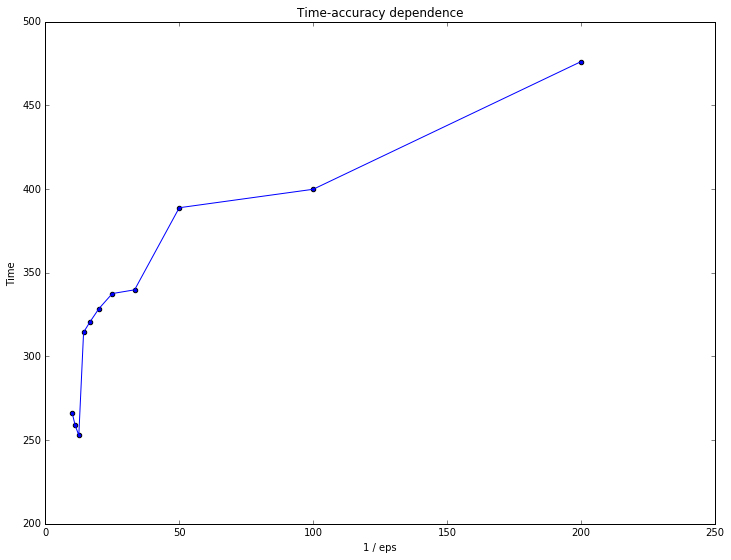

In [62]:
%matplotlib inline
def plot_eps_time(eps, times):
    plt.figure(figsize=(12,9))
    plt.scatter(1./(np.array(eps)), np.array(times))
    plt.plot(1./(np.array(eps)), np.array(times))
    plt.xlabel('1 / eps')
    plt.ylabel('Time')
    plt.title('Time-accuracy dependence')
    plt.show()
    
plot_eps_time(eps_beckmann_values, time_beckmann_values)

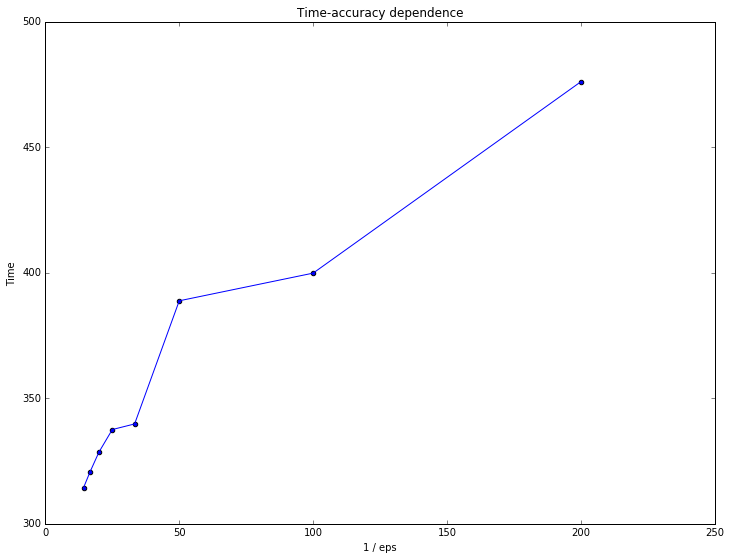

In [63]:
plot_eps_time(np.array(eps_beckmann_values)[3:], np.array(time_beckmann_values)[3:])